In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error

import matplotlib.pyplot as plt

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # insert data as a pandas dataframe
    
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input saquence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... )
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)#bvc
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [27]:
df = pd.read_csv('st0050(no_sunday).csv', index_col='ds', parse_dates=True)
df_proc = df[['n_clients','imputed']]
df_proc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23582 entries, 2015-01-02 09:00:00 to 2020-10-17 21:00:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   n_clients  23582 non-null  float64
 1   imputed    23582 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 552.7 KB


In [28]:
# CONSTANTS

TRAIN = ['2018-10', '2019-05', '2020-01']
TEST = ['2018-11', '2019-06', '2020-02']

DAY_PROC = 13
WEEK_SIZE = 6

In [29]:
feas_select = [0, 78, 156, 234, 312, 325, 338, 351, 364, 377, 384, 385, 386, 387, 388, 389]

In [30]:
mae, r2, rmse, mape, medae = 0, 0, 0, 0, 0

Test #1 ended.


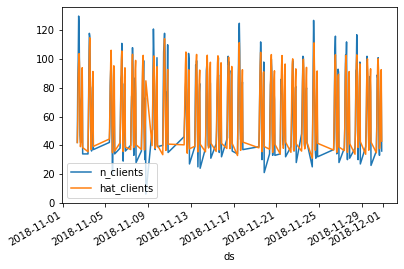

In [32]:
for test in range(len(TEST)):
    d = df_proc[:TRAIN[test]][['n_clients']]
    sc = StandardScaler()
    d['sc_clients'] = sc.fit_transform(d)

    d_test = df_proc[TEST[test]][['n_clients']]
    d_test['sc_clients'] = sc.transform(d_test)

    super_df = series_to_supervised(d[['sc_clients']], n_in=30*DAY_PROC)

    x_train = super_df.to_numpy()[:,:-1]
    y_train = np.reshape(super_df.to_numpy()[:,-1], (-1,1))
    y_test = d_test['sc_clients'].to_numpy()

    svr = LinearSVR(dual=False, loss='squared_epsilon_insensitive')
    svr.fit(x_train[:, feas_select], y_train)

    # estrutura auto-regressiva
    fea = np.append(x_train[-1,1:], y_train[-1])
    pred = svr.predict(fea.reshape(1, -1)[:, feas_select])
    y_hat = np.array(pred)
    for i in range(y_test.shape[0]-1):
        fea = np.append(fea[1:], pred)
        pred = svr.predict(fea.reshape(1, -1)[:, feas_select])
        y_hat = np.append(y_hat, pred)

    d_test['hat_clients'] = sc.inverse_transform(y_hat.reshape(-1,1))

    d_test['error'] = d_test['n_clients'] - d_test['hat_clients']

    # post-processing
    d_test['imputed'] = df[TEST[test]]['imputed']
    d_test = d_test.loc[d_test['imputed'] == -1]

    d_test[['n_clients','hat_clients']].plot()

    mae = mae + mean_absolute_error(d_test['n_clients'], d_test['hat_clients'])
    r2 = r2 + r2_score(d_test['n_clients'], d_test['hat_clients'])
    rmse = rmse + mean_squared_error(d_test['n_clients'], d_test['hat_clients'], squared=False)
    mape = mape + mean_absolute_percentage_error(d_test['n_clients'], d_test['hat_clients'])
    medae = medae + median_absolute_error(d_test['n_clients'], d_test['hat_clients'])

    #print('MAE:',mean_absolute_error(d_test['n_clients'], d_test['hat_clients']))
    #print('R2:',r2_score(d_test['n_clients'], d_test['hat_clients']))
    #print('RMSE:',mean_squared_error(d_test['n_clients'], d_test['hat_clients'], squared=False))
    #print('MAPE:',mean_absolute_percentage_error(d_test['n_clients'], d_test['hat_clients']))
    #print('MedAE:',median_absolute_error(d_test['n_clients'], d_test['hat_clients']))


    #f_name = 'proc_'+str(TEST[test])+'.csv'
    #d_test.to_csv(f_name)

    print('Test #'+str(test+1)+' ended.')
    
    #break

Text(0.5, 0, 'Test horizon')

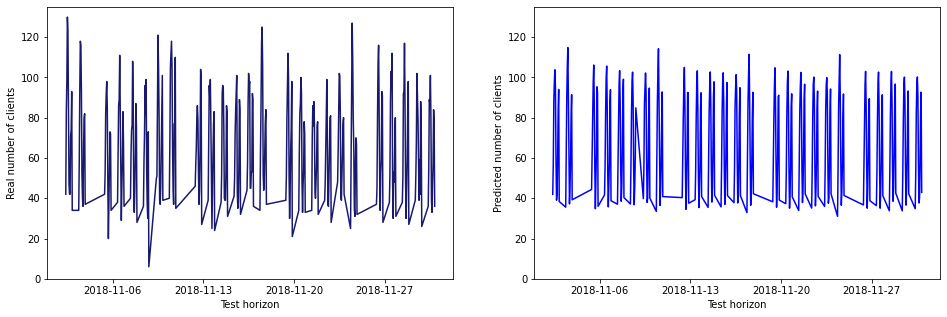

In [48]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

x = d_test.index
y1 = d_test['n_clients'].to_numpy()
y2 = d_test[['hat_clients']].to_numpy()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='midnightblue')
axes[0].set_ylim([0, 135])
axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
axes[0].set_ylabel('Real number of clients')
axes[0].set_xlabel('Test horizon')

axes[1].plot(x, y2, color='blue')
axes[1].set_ylim([0, 135])
axes[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
axes[1].set_ylabel('Predicted number of clients')
axes[1].set_xlabel('Test horizon')
#axes[1].xaxis.set_major_formatter(DateFormatter("%m-%d"))
#fig.tight_layout()

In [35]:
d_test.index

DatetimeIndex(['2018-11-02 09:00:00', '2018-11-02 10:00:00',
               '2018-11-02 11:00:00', '2018-11-02 12:00:00',
               '2018-11-02 13:00:00', '2018-11-02 14:00:00',
               '2018-11-02 15:00:00', '2018-11-02 16:00:00',
               '2018-11-02 17:00:00', '2018-11-02 18:00:00',
               ...
               '2018-11-30 12:00:00', '2018-11-30 13:00:00',
               '2018-11-30 14:00:00', '2018-11-30 15:00:00',
               '2018-11-30 16:00:00', '2018-11-30 17:00:00',
               '2018-11-30 18:00:00', '2018-11-30 19:00:00',
               '2018-11-30 20:00:00', '2018-11-30 21:00:00'],
              dtype='datetime64[ns]', name='ds', length=323, freq=None)

In [8]:
df_results = pd.DataFrame()
df_results.index = ['MAE', 'R2', 'RMSE', 'MAPE', 'MedAE']

In [9]:
df_results['store 6'] = [mae, r2, rmse, mape, medae]

In [10]:
df_results['store 5'] = [mae/3, r2/3, rmse/3, mape/3, medae/3]

In [11]:
#df_results.to_csv('mean_results_SVRprimal_16fea.csv')

In [12]:
df_results

,store 6,store 5
MAE,23.949874,7.983291
R2,2.548381,0.849460
RMSE,31.253345,10.417782
MAPE,0.441613,0.147204
MedAE,18.999131,6.333044


In [13]:
df_proc.describe()

,n_clients,imputed
count,23582.000000,23582.000000
mean,76.686625,-0.947121
std,35.762695,0.256964
min,1.000000,-1.000000
25%,48.000000,-1.000000
50%,71.000000,-1.000000
75%,100.000000,-1.000000
max,224.000000,1.000000
